In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy.optimize import curve_fit

LdivS = 5.3 * 100
dLdivS = 0.1 * 100
V = 775 * 10**(-6)
dV = 10 * 10**(-6)

In [11]:
def make_raw_plot(pressure):
    file_name = "{}torr.csv".format(pressure)

    data_table = pd.read_csv(file_name).to_numpy()

    x = data_table[:, 0]
    exp_y = data_table[:, len(data_table[0]) - 1]

    mpl.rcParams['font.size'] = 16                   # Управление стилем, в данном случаем - размером шрифта
    plt.figure(figsize = (8,8), facecolor = "white") # Создаем фигуру

    # Подписываем оси и график
    plt.title(r"График зависимости $U(t)$ при давлении $ {}~торр$".format(pressure))
    plt.ylabel(r"$U, мВ$")
    plt.xlabel(r"$t, сек$")

    x_lin = np.linspace(x[0], x[-1], 1000)
    plt.plot(x, exp_y, "b", label = "Экспериментальные данные")

    plt.grid(visible = True, which = 'major', axis = 'both', alpha = 1, linewidth = 0.9)   # Активируем сетку
    plt.grid(visible = True, which = 'minor', axis = 'both', alpha = 0.5, linestyle = ':')

    plt.minorticks_on()
    plt.tight_layout()
    plt.legend(loc = "best", fontsize = 12) # Активируем легенду графика

    plt.savefig("../graphs/raw{}.png".format(pressure))
    plt.show()

def make_raw_plot_with_correction(pressure):
    file_name = "{}torr.csv".format(pressure)

    data_table = pd.read_csv(file_name).to_numpy()

    x = data_table[:, 0]
    if len(data_table[0]) != 3:
        raise "Correction column not found"
    exp_y = data_table[:, 1]
    corr_exp_y = data_table[:, 2]

    mpl.rcParams['font.size'] = 16                   # Управление стилем, в данном случаем - размером шрифта
    plt.figure(figsize = (8,8), facecolor = "white") # Создаем фигуру

    # Подписываем оси и график
    plt.title(r"График зависимости $U(t)$ при давлении $ {}~торр$".format(pressure))
    plt.ylabel(r"$U, мВ$")
    plt.xlabel(r"$t, сек$")

    x_lin = np.linspace(x[0], x[-1], 1000)
    plt.plot(x, exp_y, "b", label = "Экспериментальные данные")
    plt.plot(x, corr_exp_y, "r", label = "Экспериментальные данные с коррекцией систематической ошибки")

    plt.grid(visible = True, which = 'major', axis = 'both', alpha = 1, linewidth = 0.9)   # Активируем сетку
    plt.grid(visible = True, which = 'minor', axis = 'both', alpha = 0.5, linestyle = ':')

    plt.minorticks_on()
    plt.tight_layout()
    plt.legend(loc = "best", fontsize = 12) # Активируем легенду графика

    plt.savefig("../graphs/raw{}.png".format(pressure))
    plt.show()

"""
input format: [[<pressure>, <color>], ...]
example:      [[80, "r"], [106, "g"]]
"""
def make_lin_plot(pressures):
    global V, dV, LdivS, dLdivS

    mpl.rcParams['font.size'] = 16                   # Управление стилем, в данном случаем - размером шрифта
    plt.figure(figsize = (8,8), facecolor = "white") # Создаем фигуру

    # Подписываем оси и график
    plt.title(r"Графики зависимости $(ln U/U_0)(t)$")
    plt.ylabel(r"$ln U/U_0$")
    plt.xlabel(r"$t, сек$")

    labeled = False
    for pressure_color in pressures:
        pressure = pressure_color[0]

        file_name = "{}torr.csv".format(pressure)

        data_table = pd.read_csv(file_name).to_numpy()

        x = data_table[:, 0]
        exp_y = data_table[:, len(data_table[0]) - 1]
        y = [np.log(exp_y[i] / exp_y[0]) for i in range(len(exp_y))]

        def func(x, k, b):
            return x * k + b

        popt, pcov = curve_fit(func, x, y, p0 = (0.0, 0.0))
        k, b = popt
        dk, db = np.sqrt(np.diag(pcov))

        x_lin = np.linspace(x[0], x[-1], 1000)
        if not labeled:
            plt.plot(x, y, "grey", label = "Экспериментальные данные", linewidth = 4)
            labeled = True
        else:
            plt.plot(x, y, "grey", linewidth = 4)
        plt.plot(x_lin, func(x_lin, k, b), pressure_color[1], label = "Аппроксимация $P = %d торр, k = %.1f * 10^{-3}$" % (pressure, k * 1000))
        # plt.errorbar(x, y, markersize = 9, markerfacecolor = 'r', label = 'Экспериментальные значения')

        EpsUarr = [0.01 / i / np.log(i / exp_y[0]) for i in exp_y[1:]]
        EpsU = sum(EpsUarr) / len(EpsUarr)
        EpsU0arr = [0.01 / exp_y[0] / np.log(i / exp_y[0]) for i in exp_y[1:]]
        EpsU0 = sum(EpsU0arr) / len(EpsU0arr)

        D = -k * V * LdivS / 2 * 10000
        dDprib = D * np.sqrt((dV/V)**2 + (dLdivS/LdivS)**2 + EpsU**2 + EpsU0**2)
        dD = np.sqrt((dk / k * D)**2 + dDprib**2)

        results = pd.DataFrame([[D, dD, k, b, dk, db]], columns = ["D", "dD", "k", "b", "dk", "db"])
        results.to_csv("mnk{}.csv".format(pressure), index = False)

    plt.grid(visible = True, which = 'major', axis = 'both', alpha = 1, linewidth = 0.9)   # Активируем сетку
    plt.grid(visible = True, which = 'minor', axis = 'both', alpha = 0.5, linestyle = ':')

    plt.minorticks_on()
    plt.tight_layout()
    plt.legend(loc = "best", fontsize = 12) # Активируем легенду графика

    plt.savefig("../graphs/log.png".format(pressure))
    plt.show()


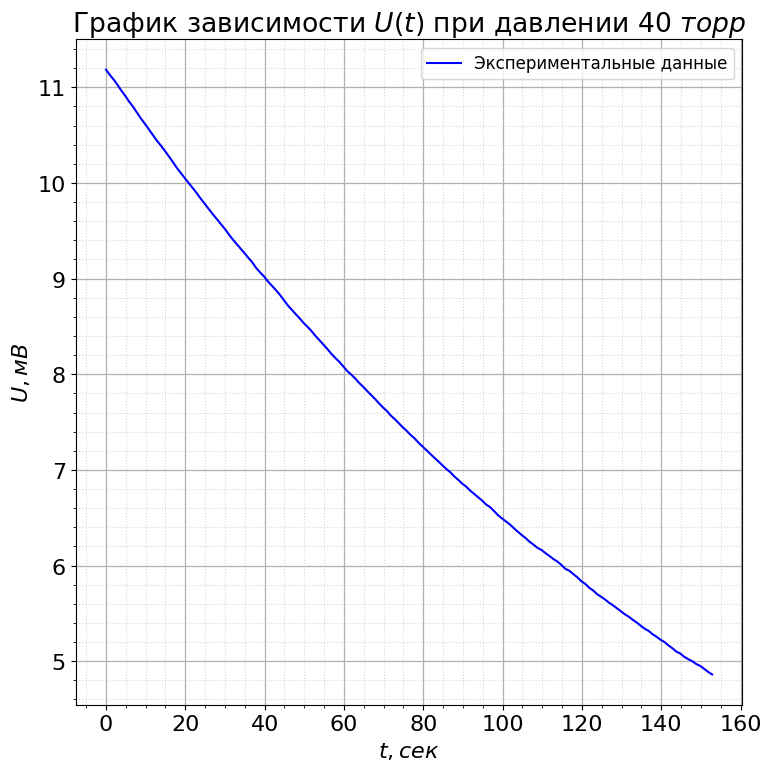

In [12]:
make_raw_plot(40)

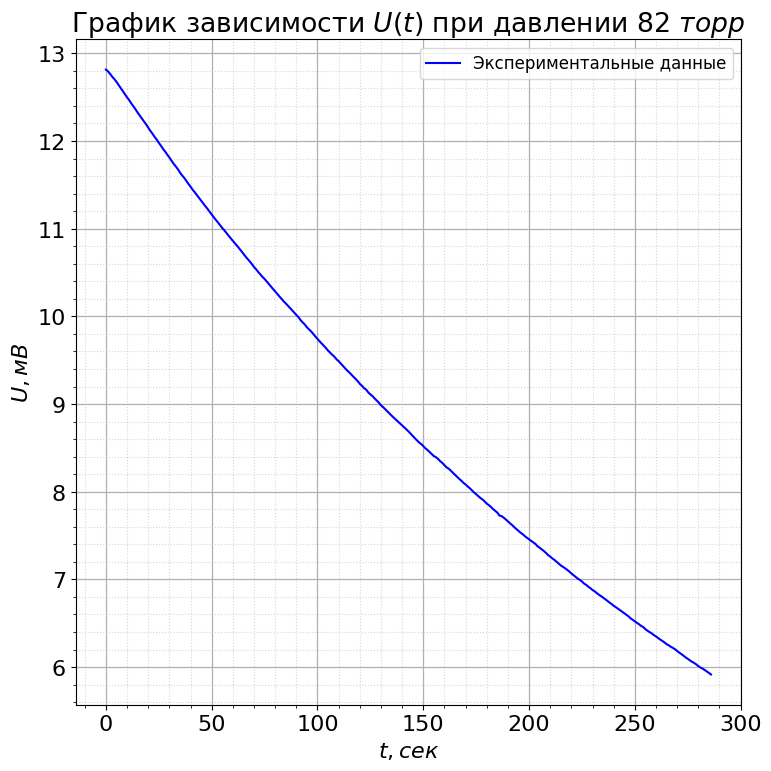

In [13]:
make_raw_plot(82)

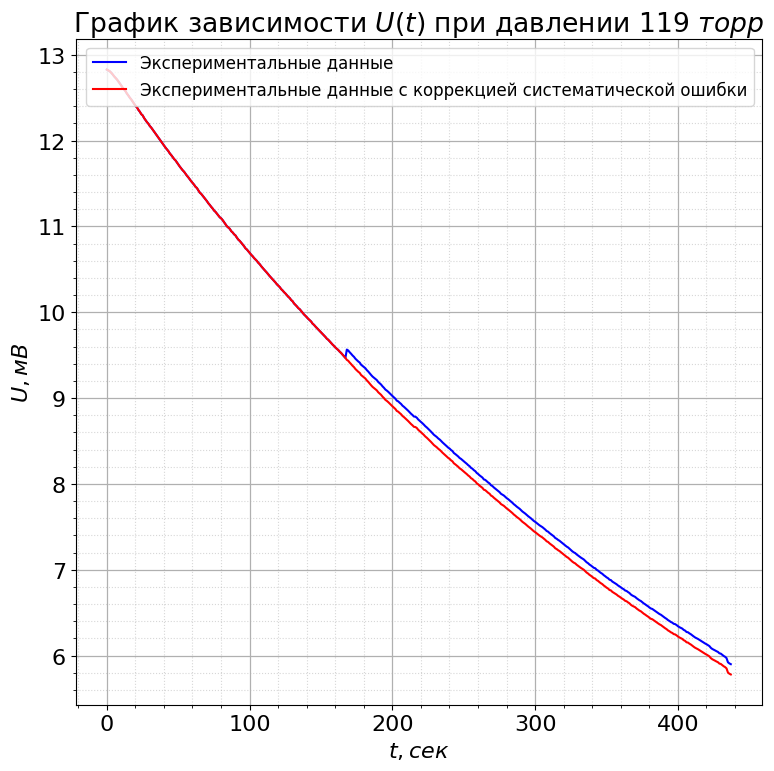

In [14]:
make_raw_plot_with_correction(119)

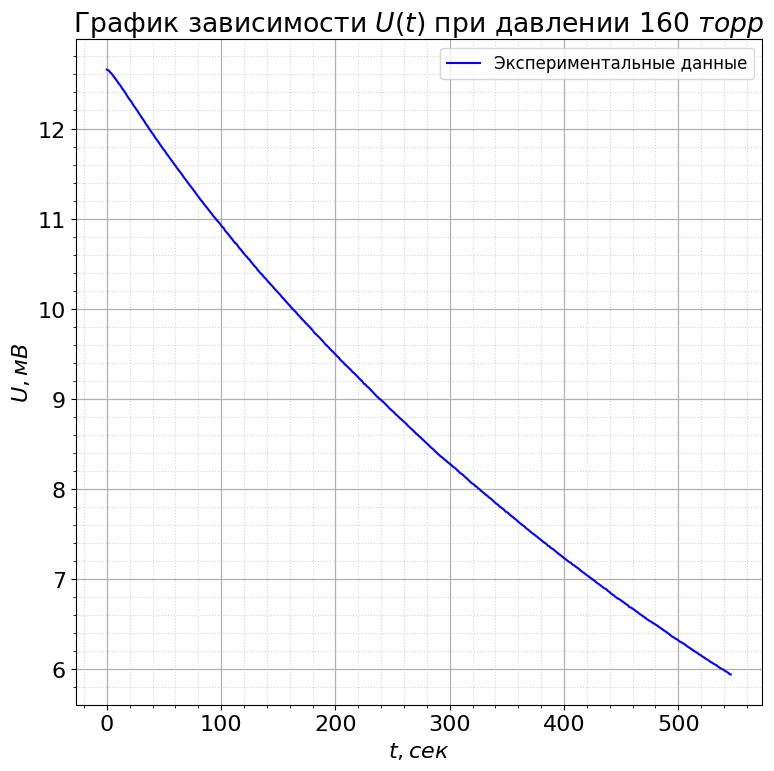

In [15]:
make_raw_plot(160)

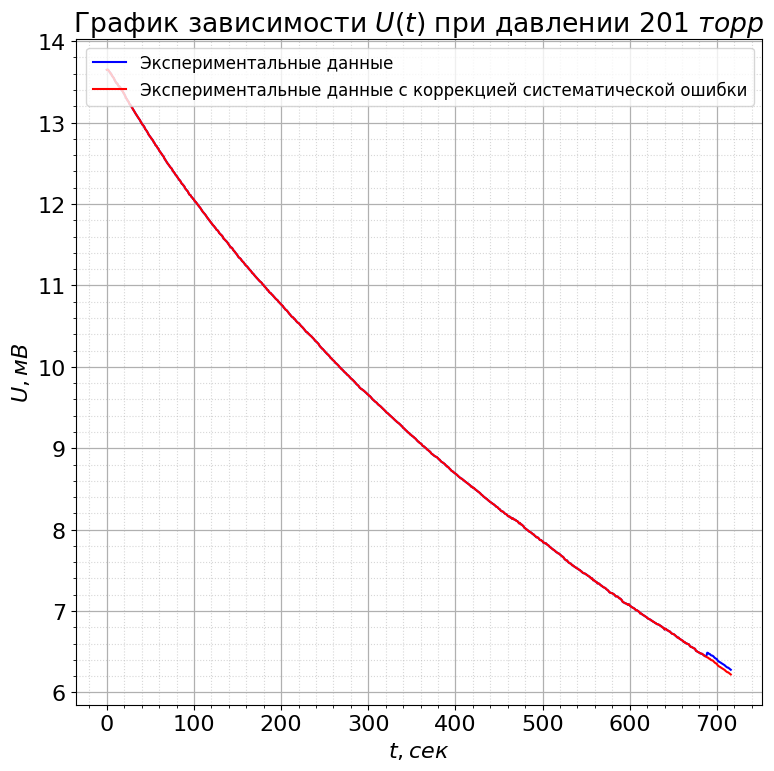

In [16]:
make_raw_plot_with_correction(201)

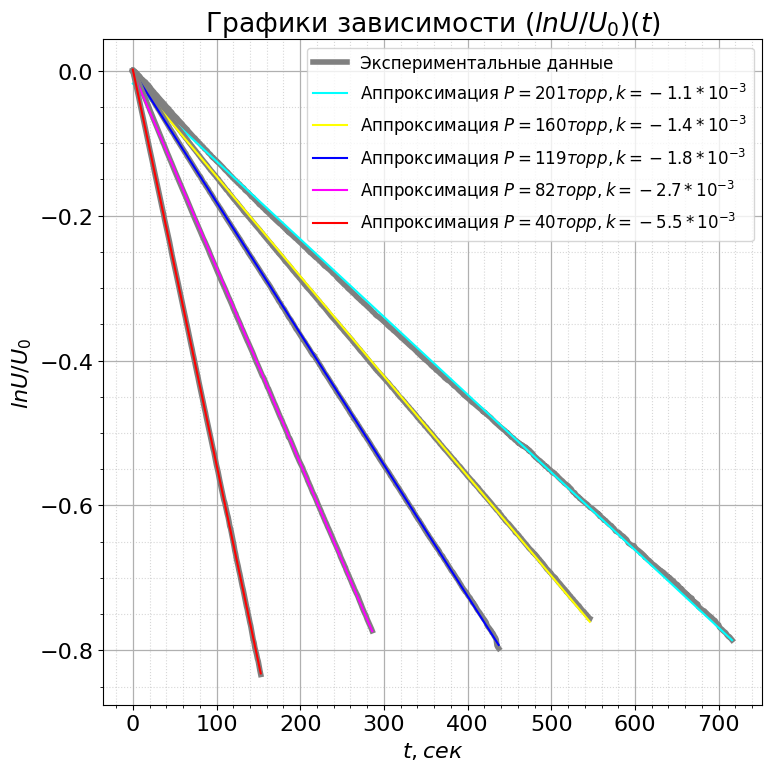

In [17]:
make_lin_plot([[40, "r"], [82, "magenta"], [119, "b"], [160, "yellow"], [201, "cyan"]][::-1])